In [29]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Concatenate


In [30]:
import pickle
with open('SmellRuleEncoded.pkl', 'rb') as f:
    smellKey_list = pickle.load(f)

# Print the contents of smell key list
print(smellKey_list)

0      java:S106\n
1      java:S106\n
2      java:S106\n
3      java:S106\n
4      java:S106\n
          ...     
88    java:S3740\n
89    java:S3776\n
90    java:S3740\n
91    java:S3776\n
92    java:S1181\n
Name: SmellRule, Length: 93, dtype: object


In [31]:
# Load embeddings (assuming they are already loaded)
df = pd.read_csv('./combined_codes_updated.csv')
df_smell = pd.read_csv("Temp_smellKey-data_encoded.csv")
embeddings = torch.load('bert_old.pt')
embeddings2 = torch.load('bert_fixed.pt')
labels = df_smell['smellKey_encoded'].values
print(labels)
print(embeddings.shape, embeddings2.shape, labels.shape)
# Combine embeddings into pairs
X = torch.stack((embeddings, embeddings2), dim=1)  # Shape: (N, 2, 768)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)



[0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 2
 1 2 2 2 2 2 2 2 1 1 2 2 2 4 2 1 2 3 1 1 2 3 3 3 2 1 1 2 2 2 1 2 2 2 2 1 3
 3 2 3 2 2 2 2 2 2 2 2 2 2 3 2 3 2 3 1]
torch.Size([140, 768]) torch.Size([140, 768]) (93,)


ValueError: Found input variables with inconsistent numbers of samples: [140, 93]

In [32]:
# Define the model, addressing the dropout warning
class TwoTimestepLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)  # Use hidden state from the last timestep
        output = self.fc(hidden[-1])
        return output

# Create model instance
model = TwoTimestepLSTM(768, 93, 1 )  # Adjust hyperparameters len(labels.unique())

# Loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# Training loop with early stopping and validation set
num_epochs = 50  # Increase epochs if needed
batch_size = 32
best_val_acc = 0
patience = 5  # Number of epochs to wait for improvement before stopping
from torch.utils.data import DataLoader, TensorDataset
# Ensure y_train is converted to a tensor if it's a NumPy array
y_train = torch.tensor(y_train, dtype=torch.float32)  # Adjust dtype as needed
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)  # Adjust dtype as needed
# Create the TensorDataset
train_data = TensorDataset(X_train, y_train)
# Define empty lists to store evaluation metrics
train_accuracy_list = []
val_accuracy_list = []
precision_list = []
recall_list = []
f1_list = []



C:\Users\huday\AppData\Local\Temp\ipykernel_8456\3584014476.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)  # Adjust dtype as needed
C:\Users\huday\AppData\Local\Temp\ipykernel_8456\3584014476.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)  # Adjust dtype as needed


In [33]:
from sklearn.metrics import precision_recall_fscore_support
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    predicted_list = []
    labels_list = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predicted_list.extend(predicted.tolist())
            labels_list.extend(labels.tolist())

    accuracy = correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(labels_list, predicted_list, average='weighted', zero_division=0)
    return accuracy, precision, recall, f1


In [34]:


for epoch in range(num_epochs):
    train_data = TensorDataset(X_train, y_train)
    #train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
    val_loss = 0
    val_acc = 0
    # Training within the loops
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        loss_function = nn.CrossEntropyLoss()
        labels = labels.unsqueeze(1)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
            # Evaluate on validation set after each epoch
        val_accuracy, val_precision, val_recall, val_f1 = evaluate(model,train_loader )
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Accuracy: {val_accuracy}, '
            f'Validation Precision: {val_precision}, Validation Recall: {val_recall}, '
            f'Validation F1 Score: {val_f1}')
        



Epoch 1/50, Validation Accuracy: 0.08035714285714286, Validation Precision: 0.006457270408163266, Validation Recall: 0.08035714285714286, Validation F1 Score: 0.011953955135773317
Epoch 1/50, Validation Accuracy: 0.08035714285714286, Validation Precision: 0.006457270408163266, Validation Recall: 0.08035714285714286, Validation F1 Score: 0.011953955135773317
Epoch 1/50, Validation Accuracy: 0.08035714285714286, Validation Precision: 0.006457270408163266, Validation Recall: 0.08035714285714286, Validation F1 Score: 0.011953955135773317
Epoch 1/50, Validation Accuracy: 0.08035714285714286, Validation Precision: 0.006457270408163266, Validation Recall: 0.08035714285714286, Validation F1 Score: 0.011953955135773317
Epoch 2/50, Validation Accuracy: 0.08035714285714286, Validation Precision: 0.006457270408163266, Validation Recall: 0.08035714285714286, Validation F1 Score: 0.011953955135773317
Epoch 2/50, Validation Accuracy: 0.08035714285714286, Validation Precision: 0.006457270408163266, Va

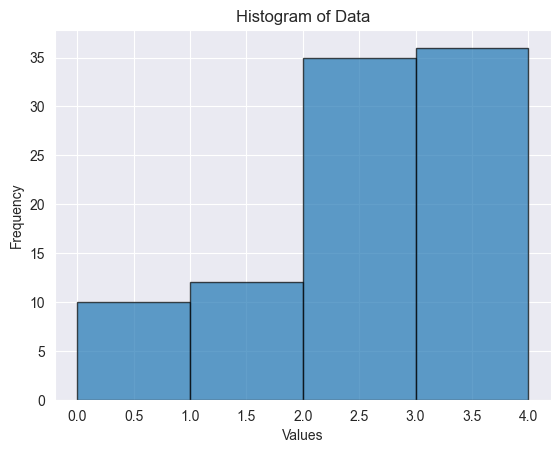

In [35]:
import matplotlib.pyplot as plt

smell = df_smell['smellKey_encoded']
plt.hist(smell, bins=range(min(smell), max(smell) + 1), edgecolor='black', alpha=0.7)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Data')
plt.grid(True)
plt.show()



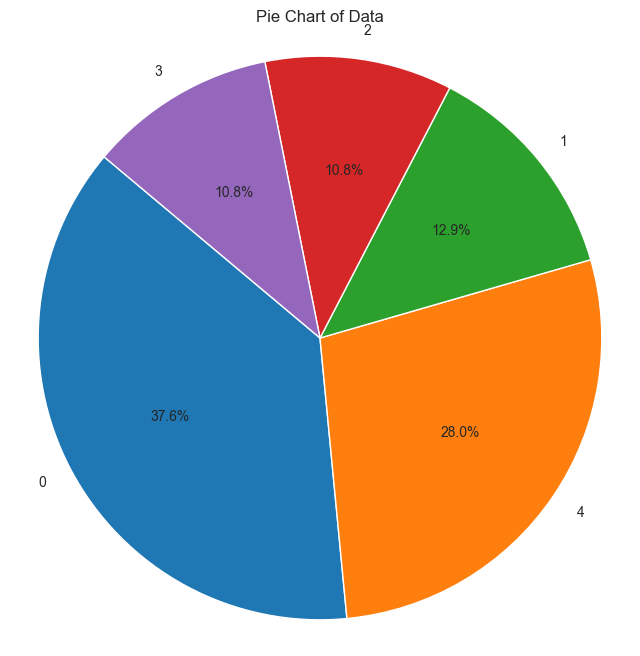

In [36]:
import matplotlib.pyplot as plt

data = df_smell['smellKey_encoded']

unique_values = data.unique()
value_counts = data.value_counts()

plt.figure(figsize=(8, 8))
plt.pie(value_counts, labels=unique_values, autopct='%1.1f%%', startangle=140)
plt.title('Pie Chart of Data')
plt.axis('equal')
plt.show()

